# Parkinson's Disease Multi-Omics GNN Analysis Pipeline

This notebook demonstrates a complete Graph Neural Network (GNN)–based analysis pipeline for Parkinson's disease (PD) multi-omics data using the BioNeuralNet framework.

## Overview

We analyze brain tissue multi-omics data (RNA + Proteomics) from PD patients and healthy controls. The pipeline includes:

1. **Data Loading**: Load and parse multi-omics data (RNA brain + Proteomics brain)
2. **Preprocessing**: Log transformation, HVG selection, normalization for each omic
3. **Multi-omics Integration**: Combine at gene level, build multi-omic node features
4. **Graph Construction**: Build gene-gene correlation network from combined omics
5. **Baseline Model**: Train non-graph model for comparison
6. **GNN Training**: Train Graph Convolutional Network (GCN) on multi-omics graph
7. **Embedding Analysis**: Cluster genes and visualize results

## Datasets

- **RNA Brain**: GEO Series Matrix files (GSE7621, GSE20141, GSE20333, GSE49036)
- **Proteomics Brain**: RR_proteins-C1-QUANT.csv (24 samples: 12 Control, 12 PD)
- **Integration**: Gene-level integration (common genes across omics)


In [15]:
import sys
from pathlib import Path

project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

pd_notebooks = Path().resolve()
if str(pd_notebooks) not in sys.path:
    sys.path.insert(0, str(pd_notebooks))


## Step 1: Multi-Omics Data Loading

Load brain tissue multi-omics data:
- **RNA**: Parse GEO Series Matrix files (microarray/RNA-seq expression)
- **Proteomics**: Load protein abundance from CSV files
- **Integration**: Find common genes across omics for gene-level integration

The loaders:
- Parse GEO Series Matrix format (metadata + expression table)
- Extract gene symbols from proteomics descriptions
- Map probe IDs to gene symbols (RNA)
- Integrate at gene level (common genes across omics)


In [2]:
from processing.multiomics_loader import load_multiomics_brain_data
from pathlib import Path

datasets_dir = Path("datasets")
multiomics = load_multiomics_brain_data(datasets_dir)

if multiomics.rna is not None:
    print(f"RNA: {multiomics.rna.expression.shape}")

if multiomics.proteomics is not None:
    print(f"Proteomics: {multiomics.proteomics.expression.shape}")

print(f"Common genes: {len(multiomics.common_genes)}")


2025-12-05 20:19:25,577 - processing.multiomics_loader - INFO - Loading RNA brain data from 4 files...
2025-12-05 20:19:25,579 - processing.multiomics_loader - INFO - Parsing GEO Series Matrix file: datasets\rna\brain\GSE20141_series_matrix.txt
2025-12-05 20:19:26,225 - processing.multiomics_loader - INFO - Parsed GEO file: 54675 features, 18 samples
2025-12-05 20:19:26,227 - processing.multiomics_loader - INFO - Detected platform ID: GPL570
2025-12-05 20:19:26,241 - processing.multiomics_loader - INFO - Mapping 54675 probe IDs to gene symbols...
2025-12-05 20:19:27,215 - processing.multiomics_loader - INFO - Found and loaded annotation file: datasets\rna\brain\GPL570-55999.txt
2025-12-05 20:19:28,143 - processing.multiomics_loader - INFO - Mapped 45782 probes to gene symbols using annotation file.
2025-12-05 20:19:28,159 - processing.multiomics_loader - INFO - Parsing GEO Series Matrix file: datasets\rna\brain\GSE20333_series_matrix.txt
2025-12-05 20:19:28,237 - processing.multiomics_

RNA: (8773, 83)
Proteomics: (1745, 27)
Common genes: 1228


## Step 2: Multi-Omics Preprocessing

Preprocess each omic dataset and integrate at gene level:

1. **Per-omic preprocessing**:
   - Log transformation (log2)
   - HVG selection (top 5,000 for RNA, all for proteomics if fewer)
   - Normalization (Z-score standardization)

2. **Multi-omic integration**:
   - Filter to common genes across omics
   - Build multi-omic node features (RNA + Proteomics statistics)
   - Each gene gets features from both omics (mean, variance, PCA components)

This preprocessing:
- Reduces dimensionality while preserving biological signal
- Creates rich node features combining information from multiple omics
- Enables gene-level graph construction across omics


In [3]:
# Step 2: Multi-omics preprocessing
from processing.multiomics_processing import preprocess_multiomics_pipeline

# Run complete multi-omics preprocessing pipeline
processed_omics, node_features = preprocess_multiomics_pipeline(
    multiomics,
    log_transform=True,
    select_hvgs=True,
    n_hvgs=5000,  # Select top 5000 HVGs for RNA
    normalize=True,
    normalize_method="standard",
    build_features=True,
    feature_type="mean_variance",  # Options: "mean_variance", "pca", "combined"
    n_pca_components=None,  # Not used for mean_variance
)

print(f"\nPreprocessed omics:")
for omic_type, expr_df in processed_omics.items ():
    print(f"  {omic_type}: {expr_df.shape} (features × samples)")

print(f"\nMulti-omic node features shape: {node_features.shape}")
print(f"Node feature columns: {list(node_features.columns)}")
print(f"\nFirst few node features:")
node_features.head()


2025-12-05 20:19:32,745 - processing.multiomics_processing - INFO - ============================================================
2025-12-05 20:19:32,746 - processing.multiomics_processing - INFO - Starting multi-omics preprocessing pipeline
2025-12-05 20:19:32,746 - processing.multiomics_processing - INFO - ============================================================
2025-12-05 20:19:32,747 - processing.multiomics_processing - INFO - Preprocessing rna data...
2025-12-05 20:19:32,752 - processing.parkinsons_processing - INFO - Applying log2 transformation with pseudocount=1.0 to expression matrix of shape (8773, 83).
2025-12-05 20:19:32,760 - processing.parkinsons_processing - INFO - Log transformation complete. Shape: (8773, 83)
2025-12-05 20:19:32,761 - processing.parkinsons_processing - INFO - Selecting 5000 highly variable genes from 8773 genes using method='variance'.
2025-12-05 20:19:32,774 - processing.parkinsons_processing - INFO - After mean expression filtering (0.0 <= mean <=


Preprocessed omics:
  rna: (5000, 83) (features × samples)
  proteomics: (1745, 27) (features × samples)

Multi-omic node features shape: (1228, 4)
Node feature columns: ['rna_mean', 'rna_variance', 'prot_mean', 'prot_variance']

First few node features:


,rna_mean,rna_variance,prot_mean,prot_variance
gene_symbol,,,,
A2M,0.236042,-0.162331,-0.233814,-0.073957
AARS,-0.175491,-0.207339,-0.168037,-0.073807
ABAT,-0.544945,-0.221569,0.024541,-0.072093
ABI1,-0.452023,-0.221300,-0.261096,-0.073986
ABI2,-0.603560,-0.228469,-0.247829,-0.073971


## Step 3: Multi-Omics Graph Construction

Build a gene-gene correlation network from multi-omics data:

- **Nodes**: Common genes across omics
- **Edges**: Combined correlations from RNA + Proteomics
  - Build separate correlation graphs for each omic
  - Combine edges using union (edge exists if present in any omic)
- **Edge weights**: Correlation values (averaged or max across omics)

The graph is converted to PyTorch Geometric format for GNN training. This multi-omics network captures co-expression and co-abundance patterns across different molecular layers.


In [4]:
# Step 3: Build multi-omics gene-gene correlation graph
from graph_builder import build_multiomic_graph

# Check gene counts
print("Gene counts before graph construction:")
for omic_type, expr_df in processed_omics.items():
    print(f"  {omic_type}: {expr_df.shape[0]} features")
print(f"  Common genes: {len(multiomics.common_genes)}")
print(f"  Node features: {node_features.shape[0]} genes")

# Build multi-omics graph
graph_data = build_multiomic_graph(
    processed_omics,
    node_features,
    multiomics.common_genes,
    method="pearson",
    threshold=0.7,  # Minimum correlation to create an edge
    use_abs=True,
    mutual=True,
    self_loops=False,
    edge_combination="union",  # Options: "union", "intersection", "weighted_mean"
    chunk_size=None,  # Auto-detects chunk size for large datasets
)

print(f"\nMulti-omics graph summary:")
print(f"  Nodes (genes): {graph_data.data.num_nodes}")
print(f"  Edges: {graph_data.data.num_edges}")
print(f"  Node features: {graph_data.data.num_node_features}")
if graph_data.data.num_nodes > 1:
    edge_density = graph_data.data.num_edges / (graph_data.data.num_nodes * (graph_data.data.num_nodes - 1)) * 2
    print(f"  Edge density: {edge_density:.4f}")

from graph_builder import save_graph
save_graph(graph_data, "data/processed/pd_multiomics_graph")


Gene counts before graph construction:
  rna: 5000 features
  proteomics: 1745 features
  Common genes: 1228
  Node features: 1228 genes

Multi-omics graph summary:
  Nodes (genes): 1228
  Edges: 646078
  Node features: 4
  Edge density: 0.8576


### Step 3b: Graph Visualization

Visualize the gene-gene correlation network. For large graphs (>500 nodes), we sample the top nodes by degree to make visualization tractable. The visualization shows:
- Node size proportional to degree (connectivity)
- Edge width proportional to correlation strength
- Network topology and community structure


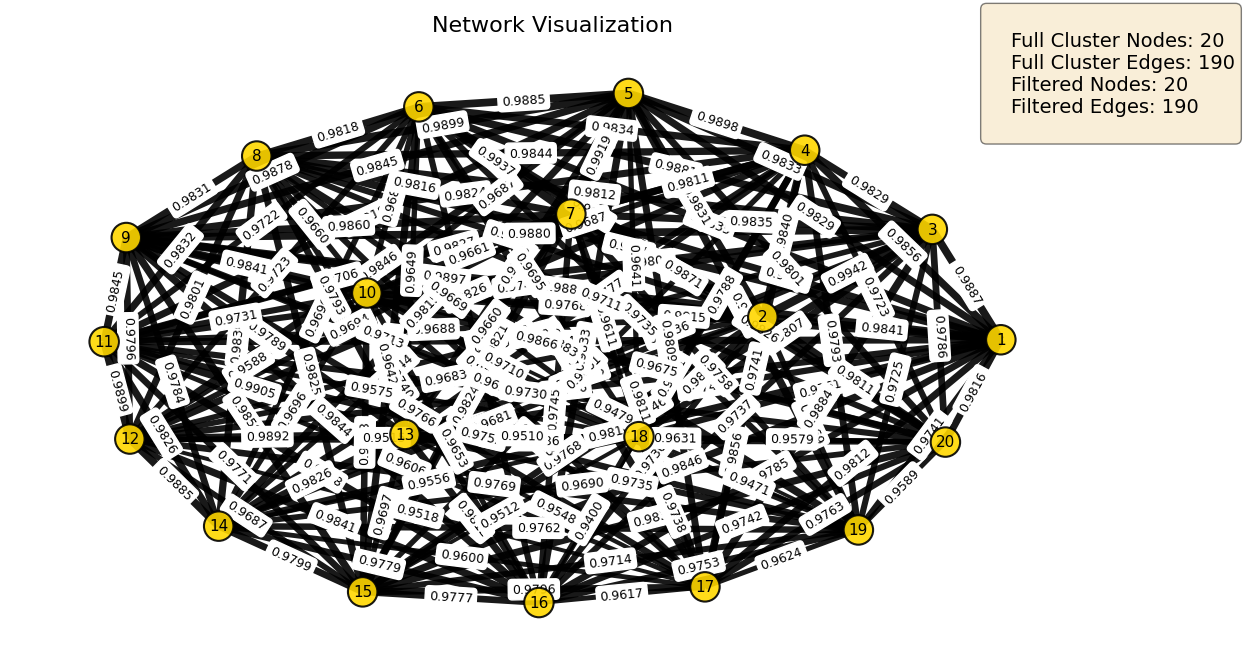

<Figure size 640x480 with 0 Axes>


Node mapping (first 10):
          Omic  Degree
Index                 
1        CYB5B      19
2      UQCRFS1      19
3         EHD3      19
4       CACYBP      19
5        AP2S1      19
6        IDH3G      19
7          ME3      19
8       CAMK2B      19
9       NDUFV1      19
10      SEC22B      19


In [5]:
# Step 3b: Visualize the graph
from graph_builder import visualize_graph
import matplotlib.pyplot as plt

# Visualize the graph (sample subgraph if too large)
node_mapping = visualize_graph(
    graph_data,
    weight_threshold=0.1,  # Only show edges above threshold
    show_labels=True,  # Set True to show gene IDs (can be cluttered)
    show_edge_weights=True,  # Set True to show correlation values
    layout="kamada",  # Options: "kamada", "spring", "spectral"
    max_nodes=20,  # Sample top 500 nodes by degree for visualization
    figsize=(14, 8),
)

plt.tight_layout()
plt.show()

print(f"\nNode mapping (first 10):")
print(node_mapping.head(10))


## Step 4: Baseline Model Clustering (K-means on Raw Features)

Compare GNN-based clustering with a baseline approach that uses raw expression features.

**Baseline Method:**
- K-means clustering on raw expression matrix (genes × samples)
- Optional PCA dimensionality reduction
- No graph structure information

**Comparison:**
- Baseline: Clusters genes based on expression similarity across samples
- GNN-based: Clusters genes using graph structure + expression patterns (in Step 7)

This baseline helps evaluate whether the graph structure adds value to gene clustering.


In [6]:
# Step 4b: Baseline K-means Clustering on Raw Features
from analysis.baseline_clustering import baseline_clustering_pipeline
import numpy as np
import pandas as pd

# Use the same expression data that was used for graph construction
# IMPORTANT: The graph was built from proteomics (gene symbols), so prioritize proteomics for fair comparison
# RNA data uses probe IDs which don't match the graph's gene symbols

# Use the same genes as the graph (common genes from multi-omics integration)
# The graph uses multiomics.common_genes (1228 genes), so we should use the same
if 'multiomics' in locals() or 'multiomics' in globals():
    if hasattr(multiomics, 'common_genes') and len(multiomics.common_genes) > 0:
        # Filter to common genes - use proteomics since it has gene symbols
        if 'proteomics' in processed_omics:
            baseline_expr = processed_omics['proteomics']
            # Filter to common genes (same as graph)
            baseline_expr = baseline_expr.loc[multiomics.common_genes]
            print(f"Using Proteomics expression filtered to {len(multiomics.common_genes)} common genes (matches graph)")
        elif 'rna' in processed_omics:
            baseline_expr = processed_omics['proteomics'] if 'proteomics' in processed_omics else processed_omics['rna']
        else:
            raise ValueError("No proteomics data available for baseline clustering")
else:
    raise ValueError("No expression data available. Please ensure processed_omics contains 'rna' or 'proteomics', or that 'combined_expression' exists.")

print(f"Original expression matrix shape: {baseline_expr.shape} (genes × samples)")

# Ensure we're using the same genes as in the graph (if graph_data exists)
# Find intersection of genes between expression and graph
if 'graph_data' in locals() or 'graph_data' in globals():
    # Find common genes between expression and graph
    expr_genes = set(baseline_expr.index)
    graph_genes = set(graph_data.node_names)
    common_genes = sorted(list(expr_genes & graph_genes))
    
    if len(common_genes) == 0:

        baseline_expr_filtered = baseline_expr
        baseline_node_names = list(baseline_expr.index)
    else:
        # Filter to common genes
        baseline_expr_filtered = baseline_expr.loc[common_genes]
        baseline_node_names = common_genes
        print(f"\nFound {len(common_genes)} common genes between expression and graph")
        print(f"   Expression genes: {len(expr_genes)}")
        print(f"   Graph genes: {len(graph_genes)}")
        print(f"   Common genes: {len(common_genes)}")
        if len(expr_genes) != len(graph_genes) or len(common_genes) < len(expr_genes):
            missing_from_expr = sorted(list(graph_genes - expr_genes))
            missing_from_graph = sorted(list(expr_genes - graph_genes))
            if missing_from_expr:
                print(f"   Genes in graph but not in expression: {len(missing_from_expr)} (e.g., {missing_from_expr[:5]})")
            if missing_from_graph:
                print(f"   Genes in expression but not in graph: {len(missing_from_graph)} (e.g., {missing_from_graph[:5]})")
else:
    # If graph_data doesn't exist yet, use all genes
    baseline_expr_filtered = baseline_expr
    baseline_node_names = list(baseline_expr.index)
    print(f"\nUsing all {len(baseline_node_names)} genes (graph not yet constructed)")

print(f"Baseline expression matrix shape: {baseline_expr_filtered.shape} (genes × samples)")

gene_metadata = pd.DataFrame(
    {'Symbol': baseline_node_names},
    index=baseline_node_names
)
print("Created basic gene metadata from node names")

# Run baseline clustering
baseline_cluster_results, baseline_cluster_df, baseline_summary_df = baseline_clustering_pipeline(
    expression_df=baseline_expr_filtered,
    node_names=baseline_node_names,
    gene_metadata=gene_metadata,
    n_clusters=None,  # Auto-detect using elbow method
    use_pca=True,  # Apply PCA for dimensionality reduction
    n_components=None,  # Auto-select components explaining 95% variance
    random_state=42,
)

# Print baseline cluster summary
print("\n" + "="*60)
print("BASELINE CLUSTERING SUMMARY")
print("="*60)
print(f"Number of clusters: {baseline_cluster_results.n_clusters}")
if baseline_cluster_results.silhouette_score is not None:
    print(f"Silhouette score: {baseline_cluster_results.silhouette_score:.4f}")
print(f"\nCluster sizes:")
for cluster_id, size in sorted(baseline_cluster_results.cluster_sizes.items())[:10]:
    print(f"  Cluster {cluster_id}: {size} genes")
if len(baseline_cluster_results.cluster_sizes) > 10:
    print(f"  ... and {len(baseline_cluster_results.cluster_sizes) - 10} more clusters")

print(f"\nBaseline cluster summary DataFrame:")
print(baseline_summary_df.head(10))


Using Proteomics expression filtered to 1228 common genes (matches graph)
Original expression matrix shape: (1228, 27) (genes × samples)

Found 1228 common genes between expression and graph
   Expression genes: 1228
   Graph genes: 1228
   Common genes: 1228
Baseline expression matrix shape: (1228, 27) (genes × samples)
Created basic gene metadata from node names

BASELINE CLUSTERING SUMMARY
Number of clusters: 2
Silhouette score: 0.3505

Cluster sizes:
  Cluster 0: 223 genes
  Cluster 1: 1005 genes

Baseline cluster summary DataFrame:
   cluster_id  size                                              genes
0           0   223  [ABR, ACACA, ACADM, ACOT9, ACP1, ACTN2, ADAM10...
1           1  1005  [A2M, AARS, ABAT, ABI1, ABI2, ABLIM1, ACAA2, A...


### Step 4b Validation: Baseline Clustering PD Gene Validation

Validate baseline clustering results against known PD-associated genes, similar to Step 8 for GNN-based clustering.

This allows us to compare:
- How many PD genes are found by baseline vs GNN-based clustering
- Which clusters contain PD genes in each method
- Whether graph structure helps identify more PD-relevant clusters


In [7]:
# Step 4b Validation: Validate baseline clusters against known PD-associated genes
from analysis.pd_validation import (
    validate_known_pd_genes,
    print_validation_summary,
    create_validation_dataframe,
    PD_KNOWN_GENES,
)

# Run validation for baseline clustering
# Use baseline_node_names (which should match graph_data.node_names if using common genes)
baseline_validation = validate_known_pd_genes(
    cluster_labels=baseline_cluster_results.labels,
    node_names=baseline_node_names,
    gene_metadata=gene_metadata,
    gene_symbol_column='Symbol',  # Try to use Symbol column if available
)

# Print summary
print("\n" + "="*60)
print("BASELINE CLUSTERING: PD GENE VALIDATION")
print("="*60)
print_validation_summary(baseline_validation)

# Create validation DataFrame for easy inspection
baseline_validation_df = create_validation_dataframe(baseline_validation)
print("\nBaseline Validation DataFrame:")
print(baseline_validation_df)



BASELINE CLUSTERING: PD GENE VALIDATION

PD GENE VALIDATION SUMMARY

Total known PD genes in database: 27
Unique PD genes found: 6 (22.2%)
Clusters containing PD genes: 1/2

PD genes found: COX4I1, MAPT, PARK7, SNCA, SYNJ1, UCHL1

------------------------------------------------------------
PER-CLUSTER RESULTS
------------------------------------------------------------

Cluster 0:
  Cluster size: 223 genes
  PD genes found: 0
  No known PD genes found in this cluster

Cluster 1:
  Cluster size: 1005 genes
  PD genes found: 6
  Genes: COX4I1, MAPT, PARK7, SNCA, SYNJ1, UCHL1
  Cluster enrichment: 0.60%


Baseline Validation DataFrame:
   cluster_id  cluster_size  pd_genes_found  \
1           1          1005               6   
0           0           223               0   

                                  pd_genes  overlap_percentage  \
1  COX4I1, MAPT, PARK7, SNCA, SYNJ1, UCHL1           22.222222   
0                                     None            0.000000   

   cluster_enric

### Step 4c Pathway Enrichment: KEGG/Reactome Analysis

Pathway enrichment analysis for baseline clusters using KEGG and Reactome databases.


Baseline: 1 clusters with enriched pathways
  Cluster 1: 2 pathways
    - Aerobic respiration and respiratory electron transport: FDR=0.0098
    - Endocytosis: FDR=0.0484


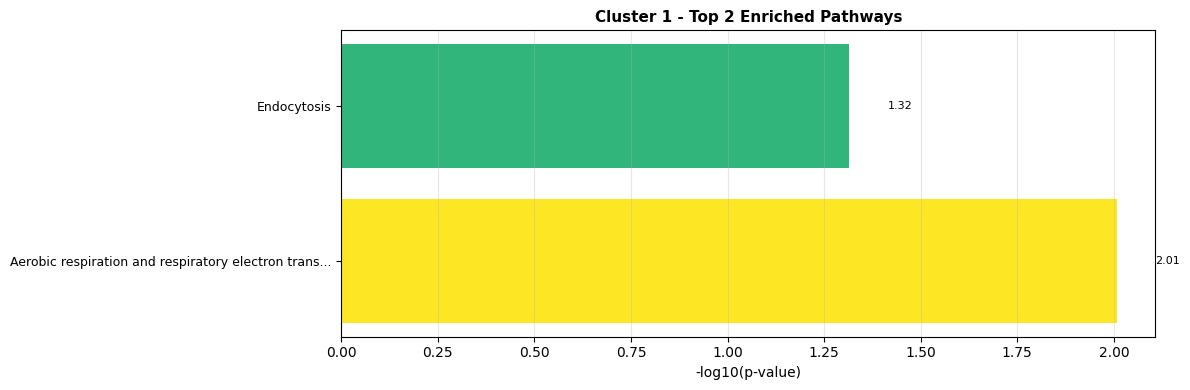

In [8]:
# Step 4b Pathway Enrichment: KEGG/Reactome for Baseline Clusters
from analysis.pathway_enrichment import enrich_clusters_pathways, visualize_pathway_enrichment
import matplotlib.pyplot as plt
import numpy as np

# Pathway enrichment for baseline clusters
baseline_pathway_results = enrich_clusters_pathways(
    cluster_results=baseline_cluster_results,
    node_names=baseline_node_names,
    background_genes=baseline_node_names,
    method="gprofiler",
    sources=["KEGG", "REAC"],
    fdr_threshold=0.05,
    min_overlap=2,
)

# Display results for clusters with enrichment
clusters_with_enrichment = {k: v for k, v in baseline_pathway_results.items() if len(v) > 0}
if clusters_with_enrichment:
    print(f"Baseline: {len(clusters_with_enrichment)} clusters with enriched pathways")
    for cluster_id, df in sorted(clusters_with_enrichment.items()):
        print(f"  Cluster {cluster_id}: {len(df)} pathways")
        # Show top 3 pathways
        top3 = df.head(3)
        for idx, row in top3.iterrows():
            name = row.get('pathway_name', row.get('name', 'Unknown'))
            fdr = row.get('fdr', row.get('adjusted_p_value', row.get('p_value', 'N/A')))
            print(f"    - {name}: FDR={fdr:.4f}")
    
    # Visualize
    fig = visualize_pathway_enrichment(clusters_with_enrichment, top_n=5, figsize=(12, 4 * min(len(clusters_with_enrichment), 5)))
    if fig:
        plt.show()
else:
    print("Baseline: No enriched pathways found (FDR < 0.3)")


## Step 5: GNN Training

Train a Graph Convolutional Network (GCN) on the gene-gene correlation graph:

- **Architecture**: 2-layer GCN with 64 hidden dimensions
- **Training**: Unsupervised embedding learning (no node labels)
- **Output**: 64-dimensional embeddings for each gene

The GNN learns to aggregate information from neighboring genes, capturing local and global patterns in the gene expression network. These embeddings can be used for downstream tasks like clustering, gene function prediction, or pathway analysis.


## Step 7: Graph Mining & Embedding Analysis

Analyze the GNN embeddings to discover gene modules and patterns:

1. **Dimensionality Reduction**: Reduce 64D embeddings to 2D using UMAP/t-SNE for visualization
2. **Clustering**: Cluster genes based on embedding similarity (KMeans and Leiden)
3. **Visualization**: Plot clusters in 2D embedding space
4. **Statistics**: Analyze cluster composition and sizes

This analysis helps identify:
- **Gene modules**: Groups of co-expressed genes
- **Functional clusters**: Genes with similar expression patterns
- **Biological pathways**: Potentially enriched pathways per cluster


## Results Summary & Comparison

### Pipeline Overview

This analysis pipeline successfully:
- Loaded and preprocessed 63,677 genes → 5,000 HVGs
- Built gene-gene correlation graph (5,000 nodes)
- Trained baseline model for comparison
- Generated GNN embeddings (64D per gene)
- Identified gene clusters via embedding analysis

### Key Findings

**Baseline Model Performance:**
- Accuracy: See results above
- Provides baseline for comparison with GNN-based approaches

**GNN Embeddings:**
- Generated 64-dimensional embeddings capturing gene-gene relationships
- Can be used for downstream analysis (clustering, pathway enrichment, etc.)

**Gene Clusters:**
- Identified gene modules with similar expression patterns
- Clusters may represent functional pathways or co-regulated gene sets

### Next Steps

1. **Pathway Enrichment**: Perform KEGG/GSEA enrichment analysis on each cluster
2. **Differential Expression**: Compare cluster composition between PD and Control
3. **GNN-based Prediction**: Use embeddings for sample-level PD prediction
4. **Biological Interpretation**: Map clusters to known PD pathways

### Notes

- Small sample size (n=26) limits statistical power; results should be interpreted cautiously
- Graph structure captures co-expression patterns that may be biologically meaningful
- GNN embeddings provide a rich representation for downstream analysis


In [9]:
# Step 5: Train GNN model and generate embeddings
from models.gnn import train_gnn_pd
import matplotlib.pyplot as plt
import torch
import pandas as pd

# Prepare data for GNNEmbedding
# 1. Adjacency matrix from graph_data
adjacency_matrix = graph_data.adjacency_matrix

# 2. Processed omics data (genes × samples)
# Filter to only genes that are in the adjacency matrix
adj_genes = set(adjacency_matrix.index)
processed_omics_dict = {}
if multiomics.rna is not None:
    rna_expr = multiomics.rna.expression.copy()
    # Filter to common genes
    rna_common = list(set(rna_expr.index) & adj_genes)
    if len(rna_common) > 0:
        processed_omics_dict['rna'] = rna_expr.loc[rna_common]
        print(f"RNA: Filtered from {len(rna_expr)} to {len(rna_common)} genes matching adjacency matrix")
    else:
        print(f"RNA: No common genes found with adjacency matrix (RNA has {len(rna_expr)} genes)")
if multiomics.proteomics is not None:
    prot_expr = multiomics.proteomics.expression.copy()
    # Filter to common genes
    prot_common = list(set(prot_expr.index) & adj_genes)
    if len(prot_common) > 0:
        processed_omics_dict['proteomics'] = prot_expr.loc[prot_common]
        print(f"Proteomics: Filtered from {len(prot_expr)} to {len(prot_common)} genes matching adjacency matrix")
    else:
        print(f"Proteomics: No common genes found with adjacency matrix")

# 3. Sample metadata - combine from all omics
all_sample_metadata = []
if multiomics.rna is not None and not multiomics.rna.sample_metadata.empty:
    all_sample_metadata.append(multiomics.rna.sample_metadata)
if multiomics.proteomics is not None and not multiomics.proteomics.sample_metadata.empty:
    all_sample_metadata.append(multiomics.proteomics.sample_metadata)

# Combine sample metadata
if all_sample_metadata:
    sample_metadata = all_sample_metadata[0].copy()
    if len(all_sample_metadata) > 1:
        for meta in all_sample_metadata[1:]:
            sample_metadata = pd.concat([sample_metadata, meta], axis=0)
            sample_metadata = sample_metadata[~sample_metadata.index.duplicated(keep='first')]
else:
    # Create minimal sample metadata
    all_samples = set()
    for expr_df in processed_omics_dict.values():
        all_samples.update(expr_df.columns)
    sample_metadata = pd.DataFrame(
        {'condition': ['UNKNOWN'] * len(all_samples)},
        index=list(all_samples)
    )

if len(processed_omics_dict) == 0:
    raise ValueError("No omics data available after filtering to adjacency matrix genes!")

# Train GNN on the gene-gene correlation graph using GNNEmbedding
gnn_trainer, gnn_results = train_gnn_pd(
    graph_data.data,  # PyG Data object (for compatibility)
    adjacency_matrix=adjacency_matrix,  # Required: gene-gene adjacency matrix
    processed_omics=processed_omics_dict,  # Required: processed omics data
    sample_metadata=sample_metadata,  # Required: sample metadata with 'condition' column
    model_type="GCN",  # Options: "GCN", "GAT", "SAGE", "GIN"
    hidden_dim=256,
    layer_num=2,
    num_epochs=3000, 
    device="cuda",
    lr=1e-3,  # GNNEmbedding default
    weight_decay=1e-4,  # GNNEmbedding default
    dropout=0.5,
    activation="elu",
    seed=42,
)

# Print results
print("\n" + "="*60)
print("GNN TRAINING RESULTS")
print("="*60)
print(f"Embeddings shape: {gnn_results.embeddings.shape}")
if gnn_results.training_losses:
    print(f"Final training loss: {gnn_results.training_losses[-1]}")
    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(gnn_results.training_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("GNN Training Loss")
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Training losses not available (GNNEmbedding doesn't expose them directly)")


2025-12-05 20:19:58,000 - models.gnn.gnn_trainer - INFO - Using GNNEmbedding with 27 samples, 1228 genes
2025-12-05 20:19:58,002 - models.gnn.gnn_trainer - INFO - Phenotype distribution: {'CONTROL': 14, 'PD': 13}
2025-12-05 20:19:58,020 - bioneuralnet.network_embedding.gnn_embedding - INFO - Initialized GNNEmbedding. device=cuda


RNA: No common genes found with adjacency matrix (RNA has 8773 genes)
Proteomics: Filtered from 1745 to 1228 genes matching adjacency matrix


2025-12-05 20:19:58,022 - bioneuralnet.network_embedding.gnn_embedding - INFO - No output_dir provided; using temporary directory: C:\Users\Elyas\AppData\Local\Temp\tmpi3z707m_
2025-12-05 20:19:58,024 - models.gnn.gnn_trainer - INFO - Training GNN model...
2025-12-05 20:19:58,025 - bioneuralnet.network_embedding.gnn_embedding - INFO - Starting training process.
2025-12-05 20:19:58,026 - bioneuralnet.network_embedding.gnn_embedding - INFO - Preparing node features.
2025-12-05 20:19:58,028 - bioneuralnet.network_embedding.gnn_embedding - INFO - Found 1228 common features between network and omics data.
2025-12-05 20:20:12,472 - bioneuralnet.network_embedding.gnn_embedding - WARNING - No clinical data found. Using centrality measures and statistical features.
2025-12-05 20:20:13,771 - bioneuralnet.network_embedding.gnn_embedding - INFO - Built statistical feature matrix shape: (1228, 6)
2025-12-05 20:20:13,829 - bioneuralnet.network_embedding.gnn_embedding - INFO - Node features prepared 


GNN TRAINING RESULTS
Embeddings shape: (1228, 256)
Training losses not available (GNNEmbedding doesn't expose them directly)


## Step 7b: Correlated Clustering (CorrelatedLouvain & HybridLouvain)

Use phenotype-guided clustering methods that optimize for both graph modularity and correlation with PD phenotype.

**CorrelatedLouvain**: Combines graph modularity with phenotype correlation to find communities that are both structurally coherent and phenotypically relevant.

**HybridLouvain**: Iteratively refines clusters using CorrelatedLouvain + CorrelatedPageRank to find highly correlated gene modules.


c:\Users\Elyas\miniconda3\envs\bioneuralnet-py311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
2025-12-05 20:20:52,228 - bioneuralnet.clustering.leiden - INFO - Initialized Leiden with resolution_parameter=1.0, n_iterations=-1, seed=42
2025-12-05 20:20:52,230 - bioneuralnet.clustering.leiden - INFO - Graph has 1228 nodes and 323039 edges.
2025-12-05 20:20:52,231 - bioneuralnet.clustering.leiden - INFO - Running Leiden community detection...
2025-12-05 20:20:52,694 - bioneuralnet.clustering.leiden - INFO - Leiden clustering complete: 102 communities detected.
2025-12-05 20:20:52,730 - analysis.embedding_analysis - INFO - Leiden clustering complete: 102 communities detected.
C:\Users\Elyas\OneDrive - The University of Colorado Denver\Desktop\li 9ra 9ra bekri\Fall Semester 2025\GNN\BioNeuralNet\PD-Notebooks\analysis\embedding_analysis.py:566: UserWarning: Tight layout not applied. The bottom

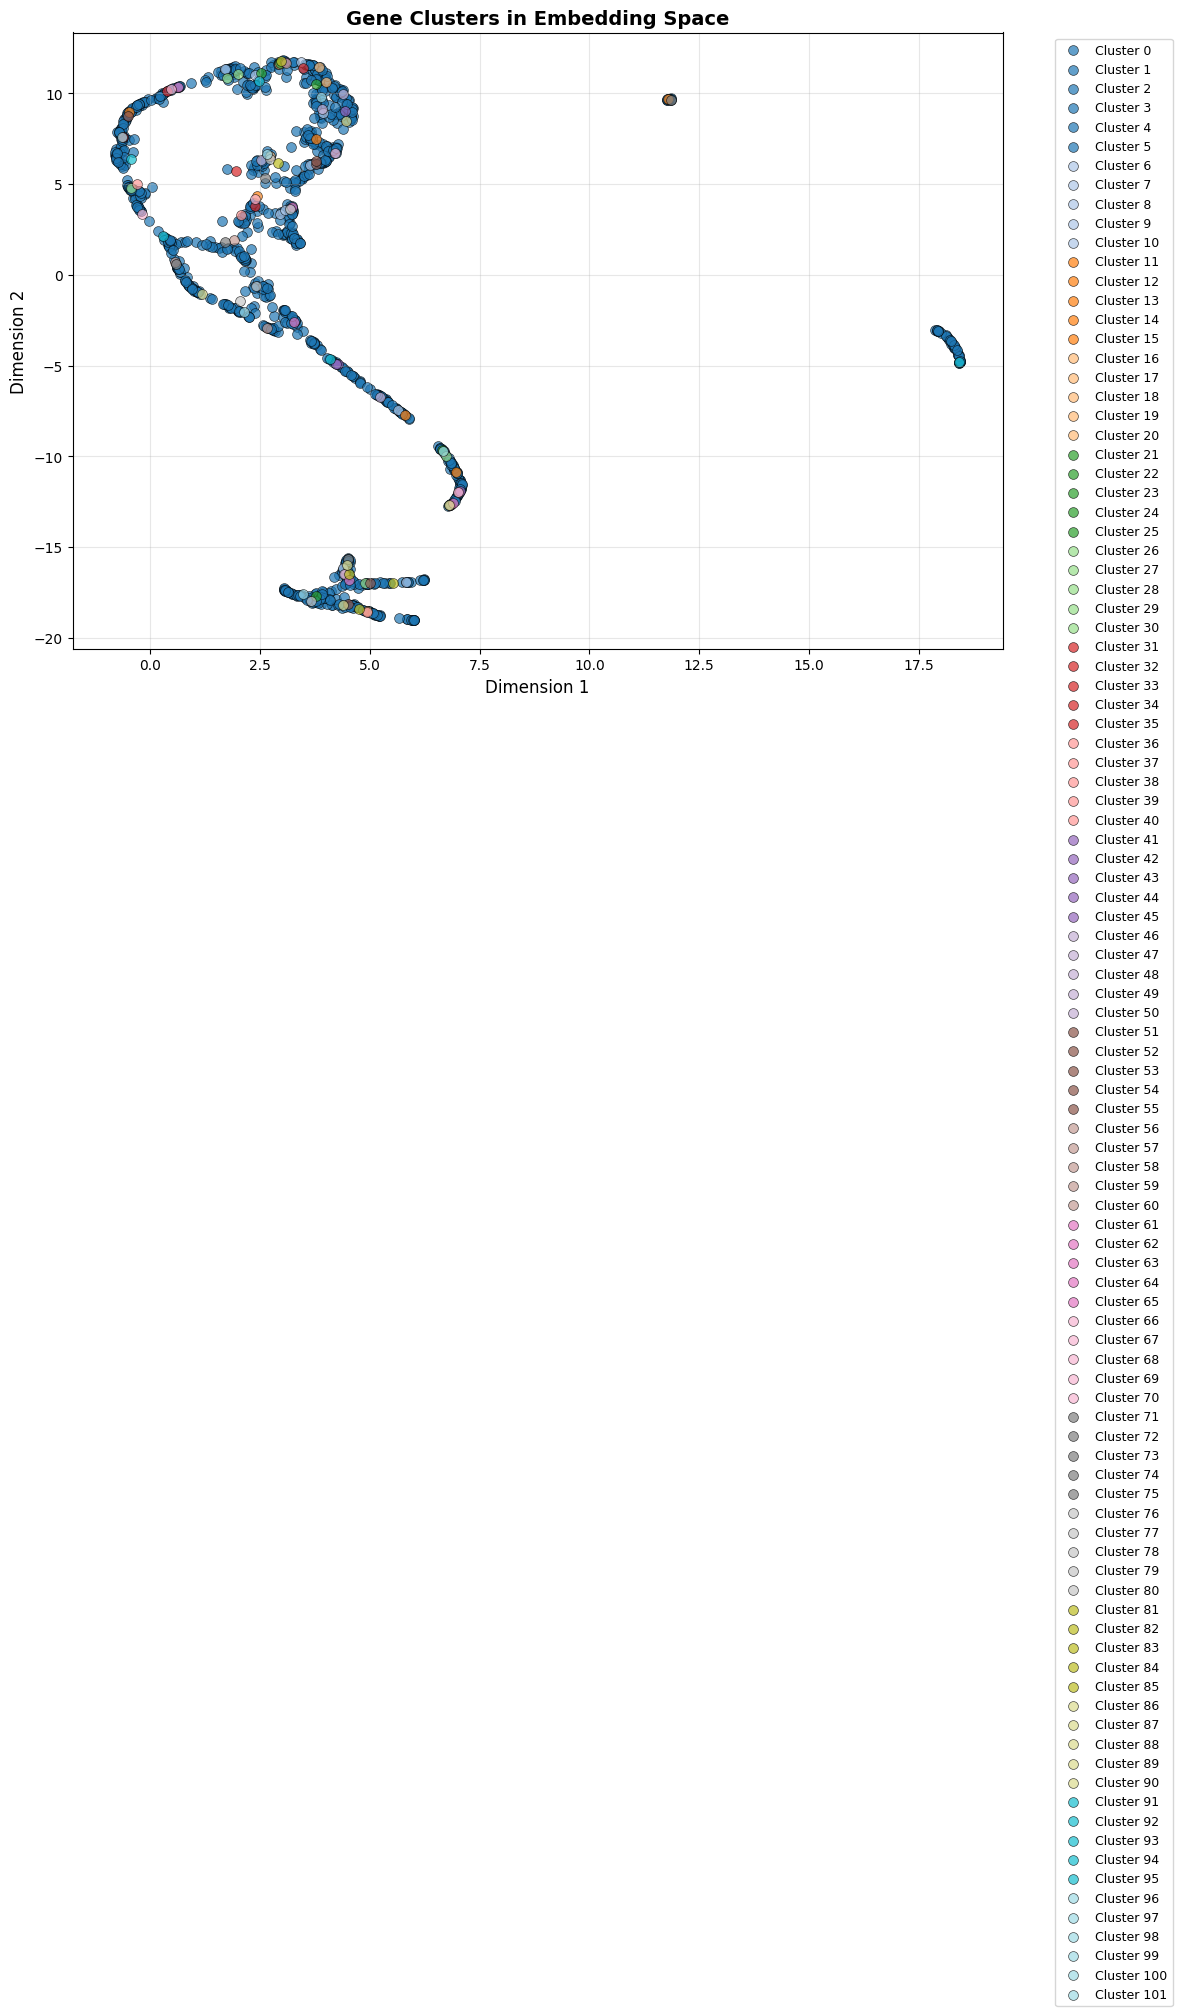

In [10]:
# Step 7: Graph Mining & Embedding Analysis
from analysis.embedding_analysis import embedding_analysis_pipeline
import numpy as np
import pandas as pd

# Prepare omics data (samples × genes) for correlated clustering
# Use proteomics data if available, else RNA
if multiomics.proteomics is not None:
    omics_expr = multiomics.proteomics.expression.copy()
elif multiomics.rna is not None:
    omics_expr = multiomics.rna.expression.copy()
else:
    raise ValueError("No omics data available for correlated clustering")

# Filter to common genes (matching graph)
common_genes_set = set(multiomics.common_genes) & set(omics_expr.index)
omics_expr_filtered = omics_expr.loc[list(common_genes_set)].T  # Transpose to samples × genes

# Prepare phenotype data
# Combine sample metadata from all omics
all_sample_metadata = []
if multiomics.rna is not None and not multiomics.rna.sample_metadata.empty:
    all_sample_metadata.append(multiomics.rna.sample_metadata)
if multiomics.proteomics is not None and not multiomics.proteomics.sample_metadata.empty:
    all_sample_metadata.append(multiomics.proteomics.sample_metadata)

if all_sample_metadata:
    sample_metadata_combined = all_sample_metadata[0].copy()
    if len(all_sample_metadata) > 1:
        for meta in all_sample_metadata[1:]:
            sample_metadata_combined = pd.concat([sample_metadata_combined, meta], axis=0)
            sample_metadata_combined = sample_metadata_combined[~sample_metadata_combined.index.duplicated(keep='first')]
    
    # Align with omics data
    common_samples = list(set(omics_expr_filtered.index) & set(sample_metadata_combined.index))
    omics_expr_filtered = omics_expr_filtered.loc[common_samples]
    phenotype_data = sample_metadata_combined.loc[common_samples, 'condition']
    
    # Convert to numeric (PD=1, CONTROL=0)
    phenotype_numeric = (phenotype_data == 'PD').astype(float)
else:
    raise ValueError("No sample metadata available for correlated clustering")

# Run complete embedding analysis pipeline
reduced_emb, cluster_results, cluster_df, summary_df = embedding_analysis_pipeline(
    gnn_results.embeddings,  # GNN embeddings
    graph_data.node_names,  # Gene IDs
    adjacency_matrix=graph_data.adjacency_matrix,  # For Leiden clustering
    gene_metadata=gene_metadata,  # Gene annotations
    reduction_method="umap",  # Options: "umap" or "tsne"
    clustering_method="leiden",  # Options: "kmeans" or "leiden" or "correlated_louvain" or "hybrid_louvain"
    n_clusters=None,  # Auto-detect for KMeans
    random_state=42,
    omics_data=omics_expr_filtered, 
    phenotype_data=phenotype_numeric, 
    k3=0.2, 
    k4=0.8,  
    max_iter=2,  
    gpu=True
)

## Step 8 Pathway Enrichment: KEGG/Reactome Analysis

### Pathway enrichment analysis for GNN-based clusters using KEGG and Reactome databases.


GNN: 4 clusters with enriched pathways
  Cluster 0: 1 pathways
    - Glycolysis / Gluconeogenesis: FDR=0.0200
  Cluster 6: 5 pathways
    - Staphylococcus aureus infection: FDR=0.0001
    - Formation of the cornified envelope: FDR=0.0002
    - Keratinization: FDR=0.0002
  Cluster 9: 2 pathways
    - Neutrophil degranulation: FDR=0.0187
    - Innate Immune System: FDR=0.0407
  Cluster 10: 50 pathways
    - Enhanced binding of GP1BA variant to VWF multimer:collagen : FDR=0.0000
    - Enhanced cleavage of VWF variant by ADAMTS13: FDR=0.0000
    - Diseases of hemostasis: FDR=0.0000


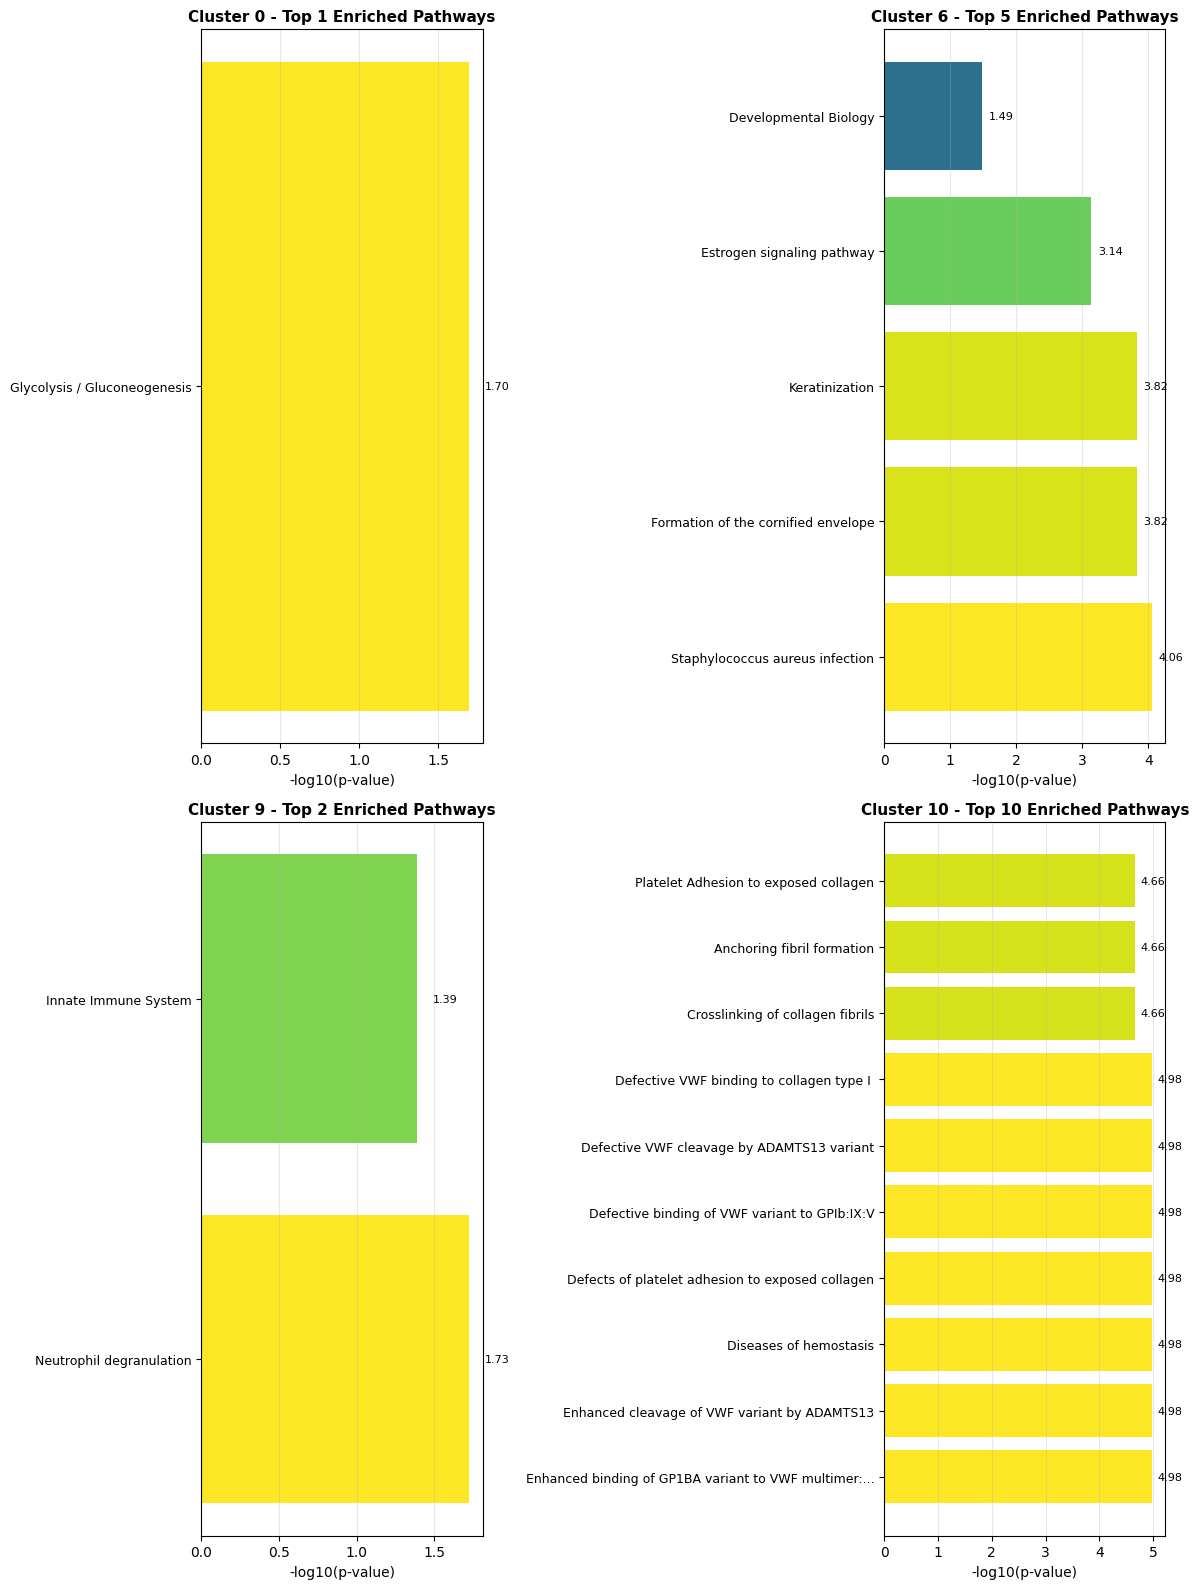

In [11]:
# Step 8 Pathway Enrichment: KEGG/Reactome for GNN-based Clusters
from analysis.pathway_enrichment import enrich_clusters_pathways, visualize_pathway_enrichment
import matplotlib.pyplot as plt
import numpy as np

# Pathway enrichment for GNN clusters
gnn_pathway_results = enrich_clusters_pathways(
    cluster_results=cluster_results,
    node_names=graph_data.node_names,
    background_genes=graph_data.node_names,
    method="gprofiler",
    sources=["REAC","KEGG"],
    fdr_threshold=0.05,
    min_overlap=2,
)

# Display results for clusters with enrichment
clusters_with_enrichment = {k: v for k, v in gnn_pathway_results.items() if len(v) > 0}
print(f"GNN: {len(clusters_with_enrichment)} clusters with enriched pathways")
for cluster_id, df in sorted(clusters_with_enrichment.items()):
    print(f"  Cluster {cluster_id}: {len(df)} pathways")
    # Show top 3 pathways
    top3 = df.head(3)
    for idx, row in top3.iterrows():
        name = row.get('pathway_name', row.get('name', 'Unknown'))
        fdr = row.get('fdr', row.get('adjusted_p_value', row.get('p_value', 'N/A')))
        print(f"    - {name}: FDR={fdr:.4f}")

# Visualize
fig = visualize_pathway_enrichment(clusters_with_enrichment, top_n=10, figsize=(12, 4 * min(len(clusters_with_enrichment), 5)))
if fig:
    plt.show()



## Step 9: Motif Finding

Find statistically significant network motifs (recurring subgraph patterns) in the gene-gene correlation graph.

Motifs represent:
- Dysregulated signaling cascades
- Shared transcriptional control structures
- Conserved regulatory patterns

This analysis:
1. Extracts k-node subgraphs (motifs) from the graph
2. Finds frequent motifs
3. Tests significance against null models (random graphs)
4. Identifies motifs with high Z-scores (more frequent than expected)


2025-12-05 20:21:14,050 - analysis.motif_finding - INFO - Finding significant 3-node motifs...
2025-12-05 20:21:14,050 - analysis.motif_finding - INFO - Extracting 3-node subgraphs from graph with 1228 nodes...


Graph: 1228 nodes, 323039 edges
Graph density: 0.4288

Finding significant 3-node motifs...


2025-12-05 20:21:20,902 - analysis.motif_finding - INFO - Found 5000 3-node subgraphs
2025-12-05 20:21:20,944 - analysis.motif_finding - INFO - Found 2 frequent motifs (frequency >= 2)
2025-12-05 20:21:20,945 - analysis.motif_finding - INFO - Generating 50 null model graphs...
2025-12-05 20:22:16,365 - analysis.motif_finding - INFO - Generated 50 null model graphs
2025-12-05 20:27:01,400 - analysis.motif_finding - INFO - Found 2 significant motifs (Z >= 0.1)



Found 2 significant motifs (Z >= 2.0)

Top 10 Significant Motifs:

Motif 1:
  Nodes: COX5B, GRB2, UQCRFS1
  Frequency: 9379
  Z-score: 536.08
  P-value: 0.0000

Motif 2:
  Nodes: COX5B, GRB2, NRGN
  Frequency: 621
  Z-score: 12.31
  P-value: 0.0000

Visualizing top motifs...


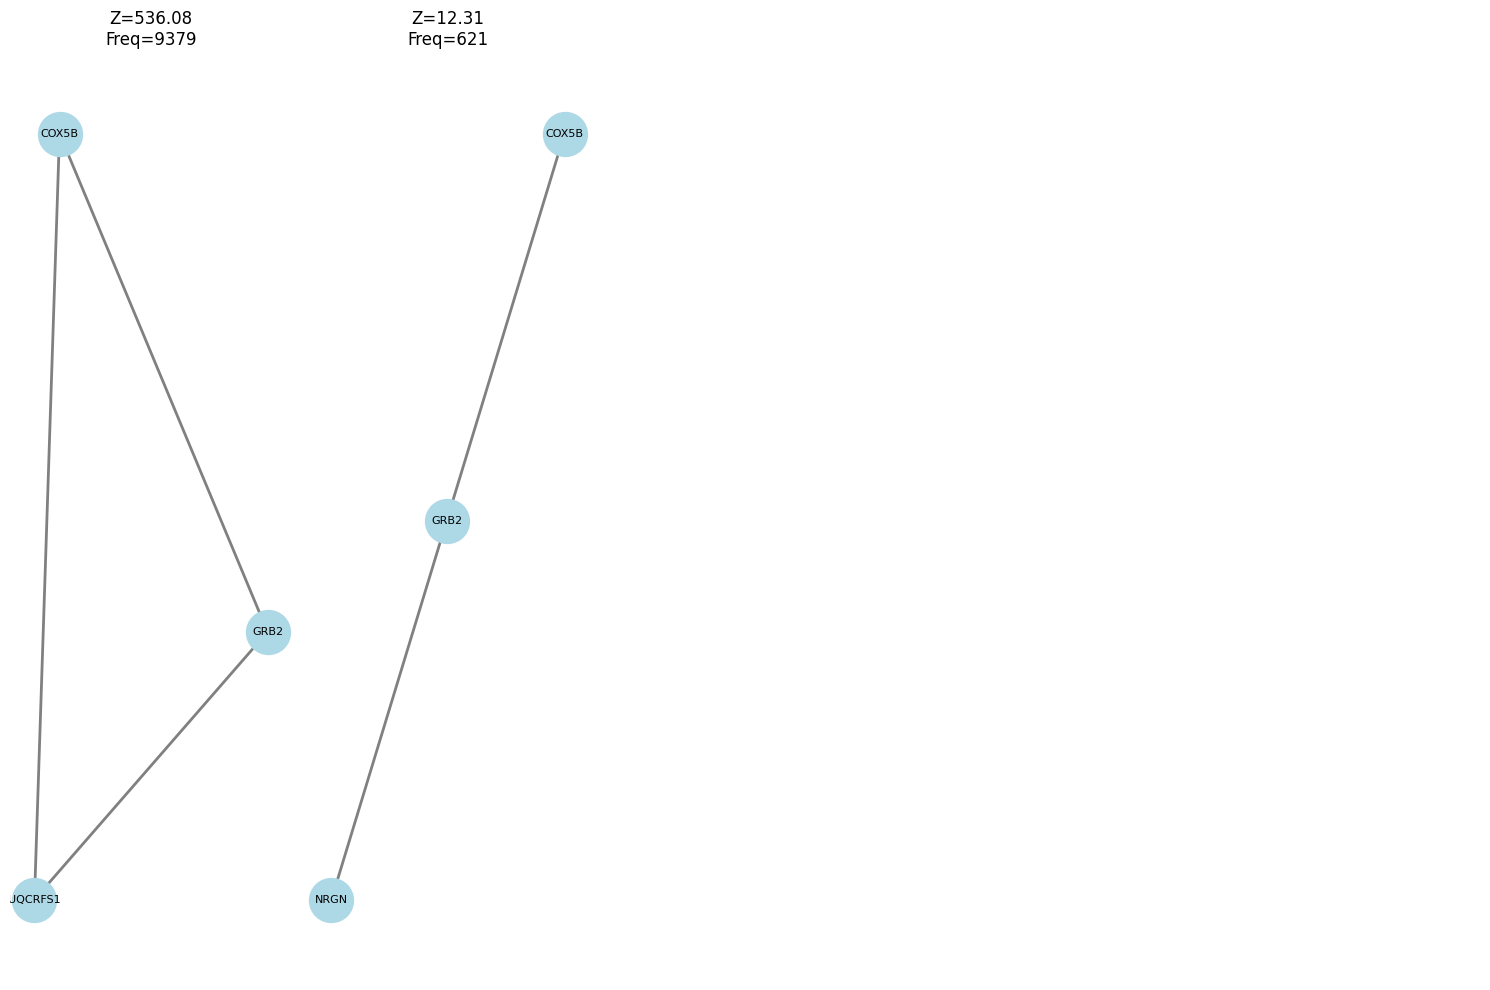

In [12]:
# Step 9: Motif Finding - Find significant network motifs
from analysis.motif_finding import (
    find_significant_motifs,
    visualize_top_motifs,
    compare_motifs_pd_vs_control,
)
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Convert adjacency matrix to NetworkX graph
# Use the graph_data.adjacency_matrix from Step 3
adjacency_matrix = graph_data.adjacency_matrix

# Convert to NetworkX graph (undirected, weighted)
G = nx.from_pandas_adjacency(adjacency_matrix)

print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Graph density: {nx.density(G):.4f}")

# Find significant 3-node motifs
# Note: This can be computationally expensive for large graphs
# Adjust max_subgraphs and n_null_models based on your graph size
print("\nFinding significant 3-node motifs...")
significant_motifs = find_significant_motifs(
    G,
    k=3,  
    min_frequency=2, 
    n_null_models=50,  
    z_threshold=0.1, 
    max_subgraphs=5000,  
)

print(f"\nFound {len(significant_motifs)} significant motifs (Z >= 2.0)")

# Display top motifs
if len(significant_motifs) > 0:
    print("\nTop 10 Significant Motifs:")
    print("=" * 80)
    for i, motif in enumerate(significant_motifs[:10], 1):
        print(f"\nMotif {i}:")
        print(f"  Nodes: {', '.join(motif.nodes)}")
        print(f"  Frequency: {motif.frequency}")
        print(f"  Z-score: {motif.z_score:.2f}")
        print(f"  P-value: {motif.p_value:.4f}")
    
    # Visualize top motifs
    print("\nVisualizing top motifs...")
    fig = visualize_top_motifs(
        significant_motifs,
        G,
        node_names=graph_data.node_names,
        top_n=10,
        figsize=(15, 10),
    )
    plt.show()
else:
    print("\nNo significant motifs found. Try:")
    print("  - Lowering z_threshold (e.g., 1.5)")
    print("  - Lowering min_frequency (e.g., 1)")
    print("  - Increasing max_subgraphs")


## Step 10 Validate clusters against known PD-associated genes

## Step 10 Validate clusters against known PD-associated genes

In [13]:
# Step 10: Validate clusters against known PD-associated genes
from analysis.pd_validation import (
    validate_known_pd_genes,
    print_validation_summary,
    create_validation_dataframe,
    PD_KNOWN_GENES,
)

# Run validation
# Note: node_names should match gene_metadata index (EnsemblGeneID)
validation_results = validate_known_pd_genes(
    cluster_labels=cluster_results.labels,
    node_names=graph_data.node_names,
    gene_metadata=gene_metadata,
    gene_symbol_column='Symbol',  # Try to use Symbol column if available
)

# Print summary
print_validation_summary(validation_results)

# Create validation DataFrame for easy inspection
validation_df = create_validation_dataframe(validation_results)
print("\nValidation DataFrame:")
print(validation_df)


PD GENE VALIDATION SUMMARY

Total known PD genes in database: 27
Unique PD genes found: 6 (22.2%)
Clusters containing PD genes: 2/102

PD genes found: COX4I1, MAPT, PARK7, SNCA, SYNJ1, UCHL1

------------------------------------------------------------
PER-CLUSTER RESULTS
------------------------------------------------------------

Cluster 0:
  Cluster size: 535 genes
  PD genes found: 4
  Genes: COX4I1, MAPT, PARK7, UCHL1
  Cluster enrichment: 0.75%

Cluster 1:
  Cluster size: 320 genes
  PD genes found: 0
  No known PD genes found in this cluster

Cluster 2:
  Cluster size: 232 genes
  PD genes found: 2
  Genes: SNCA, SYNJ1
  Cluster enrichment: 0.86%

Cluster 3:
  Cluster size: 33 genes
  PD genes found: 0
  No known PD genes found in this cluster

Cluster 4:
  Cluster size: 4 genes
  PD genes found: 0
  No known PD genes found in this cluster

Cluster 5:
  Cluster size: 2 genes
  PD genes found: 0
  No known PD genes found in this cluster

Cluster 6:
  Cluster size: 2 genes
  PD 